# Create Balrog-Bagpipes catalog 

In [1]:
import numpy as np
import create_cat as cat

## Load Balrog galaxies and assign redshift bins and n(z)s

In [2]:
balrog_data = cat.assign_balrog_zbins()

Running assign Balrog to zbins

reading pcchat...
Illegal slicing argument for scalar dataspace
just putting None
reading zp...
...success
zeropoint = 30
reading columns...
...success
reading SOMs...
...success
using overlap_weight as stored in CellMap.data

Loaded Balrog entries: 2417437
Unique Balrog sources: 267229

Assigned wide SOM using unsheared fluxes
Assigned wide SOM using sheared_1p fluxes
Assigned wide SOM using sheared_1m fluxes
Assigned wide SOM using sheared_2p fluxes
Assigned wide SOM using sheared_2m fluxes
Completed wide SOM assignment
Completed deep SOM assignment

Assigned tomographic bins
Assigned photometric redshift cell (pzc)


## Load Bagpipes physical properties

In [3]:
bagpipes_data = cat.merge_bagpipes()

Running merge Bagpipes runs

Length of Bagpipes catalog 1: 489046
Length of Bagpipes catalog 2: 358370
Length of Bagpipes catalog 3: 358371
Length of Bagpipes catalog 4: 358370
Length of Bagpipes catalog 5: 358371
Length of Bagpipes extra COSMOS catalog: 57997

Length of merged Bagpipes catalogs: 1979779


## Merge Balrog-Bagpipes

In [4]:
data = cat.merge_balrog_bagpipes(balrog_data, bagpipes_data)

Running merge Balrog with Bagpipes

Length of Balrog single sources matching by coordinates with Bagpipes: 267229
Length of Balrog data matching with Bagpipes: 2417437


## Reweight n(z)s

In [5]:
data['overlap_weight'] = cat.apply_nzs_weighting(data['unsheared/snr'], data['unsheared/T'], data['unsheared/size_ratio'])
data['pzc_weighted'] = data['pzc'] * data['overlap_weight']/np.mean(data['overlap_weight']) # Mean weight is 1

Shear weights adjusted
Response weights adjusted


## Drop some columns

In [6]:
data = data.drop(columns=cat.columns_to_drop)

## Save catalog

In [7]:
file_out = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data.to_pickle(file_out)

# Load Balrog-Bagpipes catalog

In [1]:
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [4]:
for i in range(4):
    print(f'Length of Balrog-Bagpipes Bin{i}: {len(data[data["bin"]==i])}')

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


## Make some plots

In [5]:
from plot_utils import *
import nz_utils as nz

### n(z)s

In [6]:
pz_bin = np.array([
    np.mean(data['pzc_weighted'][data['bin'] == i], axis=0)
    for i in range(4)
])
pz_bin_pileup = np.array([nz.pile_up(pz) for pz in pz_bin])

bin_width = 0.01
z = np.linspace(0, 6.0, len(pz_bin[0]))
z3 = np.linspace(0, 2.99, len(pz_bin_pileup[0]))
dz = np.append(np.diff(z), bin_width)
dz3 = np.append(np.diff(z3), bin_width)

def smooth_and_normalize(pz, z_grid, dz_grid):
    smoothed = nz.remove_spikes_savgol(z_grid, pz)
    return nz.pz_normalization(dz_grid, smoothed)

pz_bin_smooth = np.array([smooth_and_normalize(pz, z, dz) for pz in pz_bin])
pz_bin_pileup_smooth = np.array([smooth_and_normalize(pz, z3, dz3) for pz in pz_bin_pileup])

z_mean_bin = np.array([nz.mean_z(pz) for pz in pz_bin])
z_mean_pileup = np.array([nz.mean_z(pz) for pz in pz_bin_pileup])
z_mean_smooth = np.array([nz.mean_z(pz) for pz in pz_bin_smooth])
z_mean_pileup_smooth = np.array([nz.mean_z(pz) for pz in pz_bin_pileup_smooth])

print('Mean z (original):         ', z_mean_bin)
print('Mean z (smoothed):         ', z_mean_smooth)
print('Mean z (pileup):           ', z_mean_pileup)
print('Mean z (pileup smoothed):  ', z_mean_pileup_smooth)

Mean z (original):          [0.33973083 0.50761473 0.73457933 0.91327462]
Mean z (smoothed):          [0.33935739 0.50734721 0.73453565 0.91315606]
Mean z (pileup):            [0.33933981 0.50698806 0.73399801 0.9124817 ]
Mean z (pileup smoothed):   [0.33850784 0.50630387 0.73372052 0.91196903]


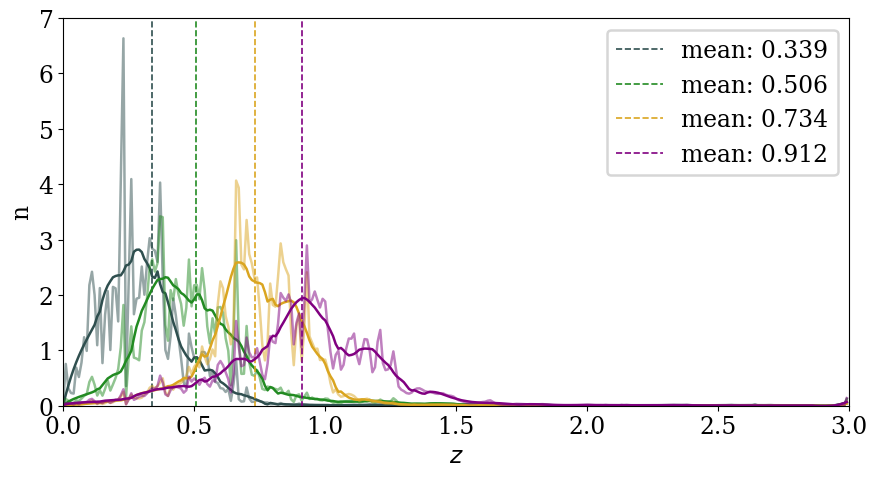

In [7]:
fig = plt.figure(figsize=(9, 5))
ax = fig.gca()

for i in range(4):
    ax.plot(z3, pz_bin_pileup[i], alpha=0.5, color=colors_bin[i])
    ax.plot(z3, pz_bin_pileup_smooth[i], color=colors_bin[i])
    plot_vline(ax, z_mean_pileup_smooth[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(z_mean_pileup_smooth[i]))

axis_settings(ax, z_params)
ax.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/nzs_hist_full.png', dpi=200, bbox_inches='tight')
plt.show()

### Physical properties

In [8]:
stell_mean = [np.mean(data['stell_best'][data['bin']==i]) for i in range(4)]
ssfr_mean = [np.mean(data['ssfr_best'][data['bin']==i]) for i in range(4)]

print('Mean stellar mass:  ', stell_mean)
print('Mean ssfr:        ', ssfr_mean)

stell_median = [np.median(data['stell_best'][data['bin']==i]) for i in range(4)]
ssfr_median = [np.median(data['ssfr_best'][data['bin']==i]) for i in range(4)]

print('\nMedian stellar mass:', stell_median)
print('Median ssfr:      ', ssfr_median)

Mean stellar mass:   [9.43292, 9.757358, 10.172263, 10.060559]
Mean ssfr:         [-9.764902, -10.249733, -10.383334, -10.026551]

Median stellar mass: [9.424247, 9.778841, 10.196053, 10.106406]
Median ssfr:       [-9.485851, -9.4915905, -9.451447, -9.419115]


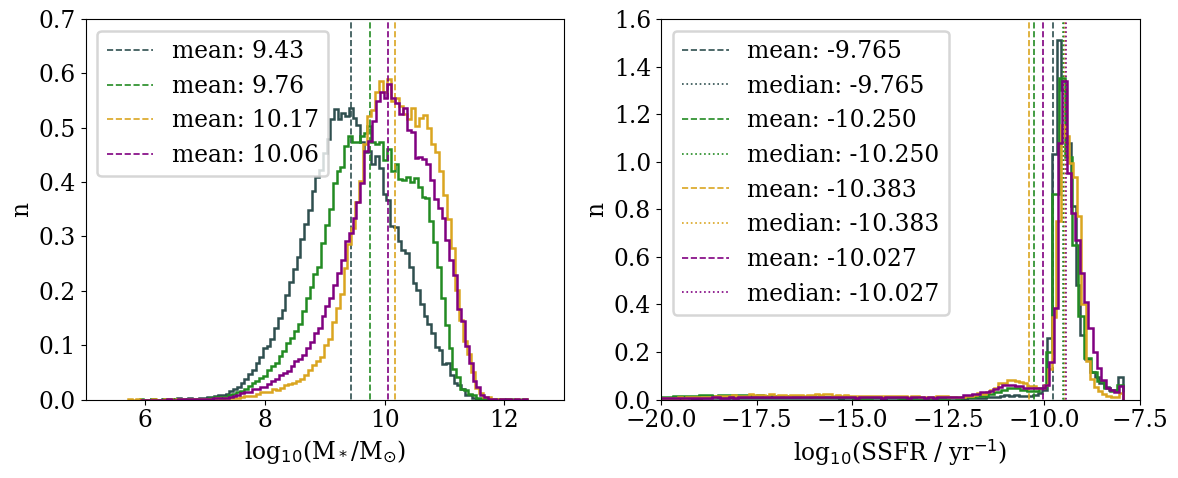

In [9]:
fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1,2,1)
for i in range(4):
    ax1.hist(data['stell_best'][data['bin']==i], bins=100, histtype='step', density=True, color=colors_bin[i])
    plot_vline(ax1, stell_mean[i], color=colors_bin[i], label='mean: '+'{:.2f}'.format(stell_mean[i]))
axis_settings(ax1, stell_params)
ax1.legend()

ax2 = plt.subplot(1,2,2)
for i in range(4):
    ax2.hist(data['ssfr_best'][data['bin']==i], bins=500, histtype='step', density=True, color=colors_bin[i])
    plot_vline(ax2, ssfr_mean[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(ssfr_mean[i]))
    plot_vline(ax2, ssfr_median[i], color=colors_bin[i], ls=':', label='median: '+'{:.3f}'.format(ssfr_mean[i]))
axis_settings(ax2, ssfr_params)
ax2.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/stell_ssfr_hist_full.png', dpi=200, bbox_inches='tight')
plt.show()

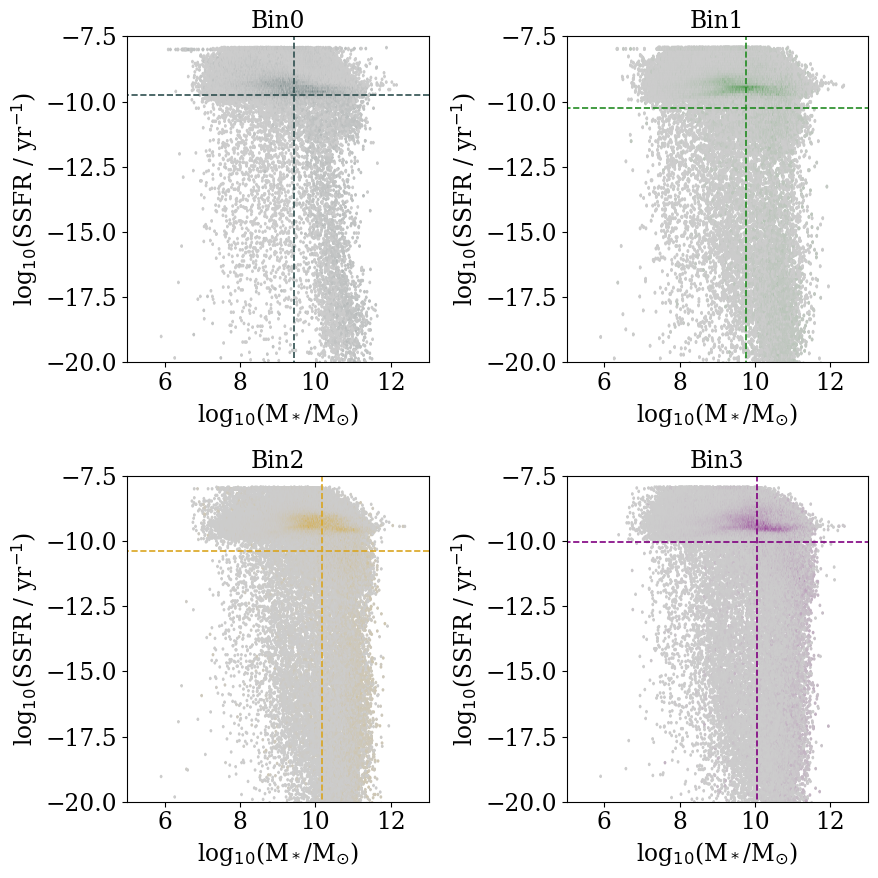

In [10]:
fig = plt.figure(figsize=(9, 9))

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.set_title(f'Bin{i}')
    ax.hexbin(data['stell_best'][data['bin']==i], data['ssfr_best'][data['bin']==i], gridsize=1500, cmap=colormaps_bin[i], mincnt=1)
    plot_vline(ax, stell_mean[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(stell_mean[i]))
    plot_hline(ax, ssfr_mean[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(ssfr_mean[i]))

    ax.set_xlim(stell_params['xlim'])    
    ax.set_ylim(ssfr_params['xlim'])
    ax.set_xlabel(stell_params['xlabel'])
    ax.set_ylabel(ssfr_params['xlabel'])

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/stell_ssfr_plots_full.png', dpi=200, bbox_inches='tight')
plt.show()

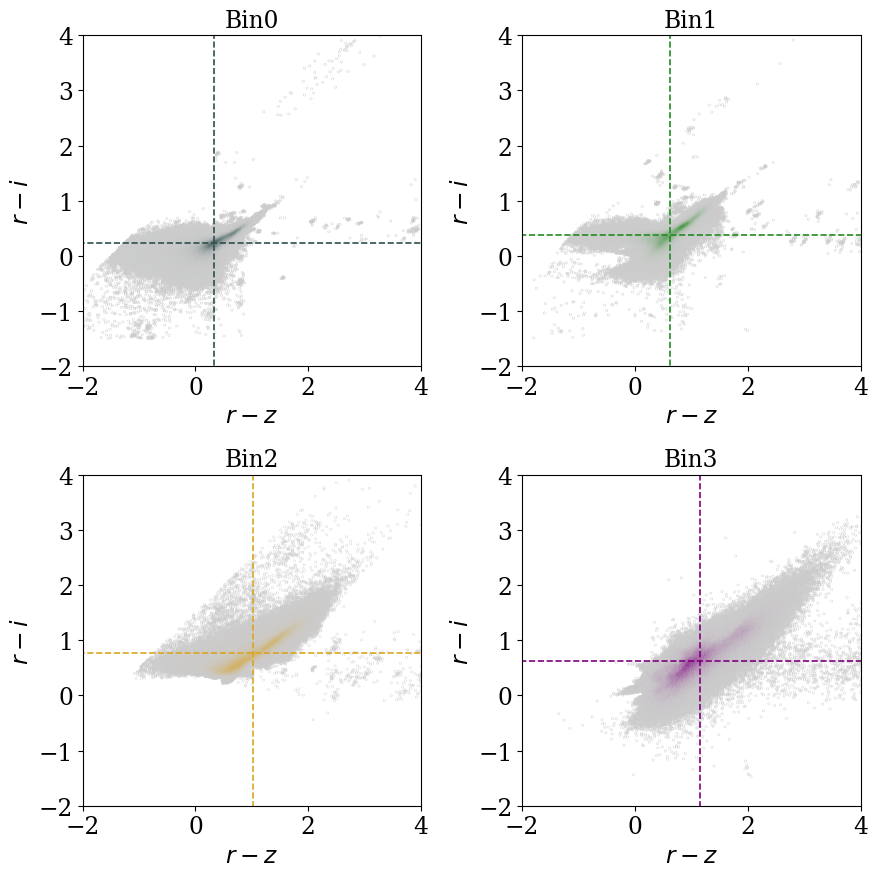

In [11]:
fig = plt.figure(figsize=(9, 9))

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.set_title(f'Bin{i}')
    ax.hexbin((flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_z'][data['bin']==i])),
              (flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_i'][data['bin']==i])),
              gridsize=1500, cmap=colormaps_bin[i], mincnt=1)
    plot_vline(ax, np.mean(flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_z'][data['bin']==i])), color=colors_bin[i])
    plot_hline(ax, np.mean(flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_i'][data['bin']==i])), color=colors_bin[i])
    ax.set_xlim(-2, 4)    
    ax.set_ylim(-2, 4)    
    ax.set_xlabel(r'$r-z$')
    ax.set_ylabel(r'$r-i$')

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/r-z_r-i_plots_full.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(9, 9))

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.set_title(f'Bin{i}')
    ax.hexbin((flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_z'][data['bin']==i])),
              data['stell_best'][data['bin']==i], gridsize=1500, cmap=colormaps_bin[i], mincnt=1)
    plot_vline(ax, np.mean(flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_z'][data['bin']==i])),  color=colors_bin[i])
    plot_hline(ax, stell_mean[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(stell_mean[i]))
    ax.set_xlim(-2, 4)    
    ax.set_ylim(stell_params['xlim'])
    ax.set_xlabel(r'$r-z$')
    ax.set_ylabel(stell_params['xlabel'])

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/r-z_stell_plots_full.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()

for i in range(4):
    #plot_vline(ax, np.mean(flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_z'][data['bin']==i])), color=colors_bin[i])
    #plot_hline(ax, np.mean(flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_i'][data['bin']==i])), color=colors_bin[i])

    sample = (data[data['bin']==i]).sample(n=10000, random_state=42)
    sns.kdeplot(
        x=(flux2mag(sample['unsheared/flux_r'])-flux2mag(sample['unsheared/flux_z'])),
        y=(flux2mag(sample['unsheared/flux_r'])-flux2mag(sample['unsheared/flux_i'])),
        levels=[0.68, 0.95], 
        color=colors_bin[i],
        fill=False
    )
    
ax.set_xlim(0, 1.6)    
ax.set_ylim(0, 1.6)    
ax.set_xlabel(r'$r-z$')
ax.set_ylabel(r'$r-i$')

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/r-z_r-i_plot_full.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()

for i in range(4):
    #plot_vline(ax, np.mean(flux2mag(data['unsheared/flux_r'][data['bin']==i])-flux2mag(data['unsheared/flux_z'][data['bin']==i])), color=colors_bin[i])
    #plot_hline(ax, stell_mean[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(stell_mean[i]))

    sample = (data[data['bin']==i]).sample(n=10000, random_state=42)
    sns.kdeplot(
        x=(flux2mag(sample['unsheared/flux_r'])-flux2mag(sample['unsheared/flux_z'])),
        y=sample['stell_best'],
        levels=[0.68, 0.95], 
        color=colors_bin[i],
        fill=False
    )
    
ax.set_xlim(0, 1.7)    
ax.set_ylim(8, 12)
ax.set_xlabel(r'$r-z$')
ax.set_ylabel(stell_params['xlabel'])

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/r-z_stell_plot_full.png', dpi=200, bbox_inches='tight')
plt.show()